# **Final Project**
**Loan Approval Prediction**<br>
<br>Christian Bae<br>
CECS 456-02<br>
ID:027139643

* Below are the necessary libraries I used in this project
* Then we try to load the dataset given (credtit_risk dataset.csv), if failed will print Error statement.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE

# Load the dataset
try:
    df = pd.read_csv('credit_risk_dataset.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: loan_data.csv not found.")
    exit()

Dataset loaded successfully.


**---------------------------**
**1. Data Preprocessing**
**---------------------------**

The code below prepares the credit risk dataset for modeling<br><br> First separating features (X) and the target variable (y), then identifying numerical and categorical feature types. Missing values are handled through median imputation for numerical features and mode imputation for categorical ones, followed by outlier removal in the 'person_income' column. <br><br>ColumnTransformer is used to scale numerical features and one-hot encode categorical features. The processed data is split into training and testing sets, and SMOTE is used to address class imbalance in the training data. Finally, the resampled training data and the test data are converted into DataFrames, and their shapes are printed.

In [2]:
print("\n--- 1. Data Preprocessing ---")

# --- Separate Features and Target ---
X = df.drop('loan_status', axis=1)
y = df['loan_status']

# --- Identify Numerical and Categorical Features ---
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# --- Handle Missing Values ---
for col in numerical_features:
    X[col] = X[col].fillna(X[col].median())

for col in categorical_features:
    X[col] = X[col].fillna(X[col].mode()[0])  # Or a constant like 'Missing'

# --- Handle Outliers (Example) ---
upper_threshold = X['person_income'].quantile(0.99)
X = X[X['person_income'] <= upper_threshold]
y = y[X.index]  # Keep y aligned with filtered X

# --- Create Preprocessor ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

# --- Apply Preprocessor ---
X_processed = preprocessor.fit_transform(X)
feature_names = preprocessor.get_feature_names_out()  # Use default if input_features is problematic
X_processed_df = pd.DataFrame(X_processed, columns=feature_names)

# --- Split the Dataset ---
X_train, X_test, y_train, y_test = train_test_split(X_processed_df, y, test_size=0.2, random_state=42, stratify=y)

# --- Handle Imbalanced Data ---
print("\nClass distribution before SMOTE:")
print(y_train.value_counts())

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\nClass distribution after SMOTE:")
print(y_train_resampled.value_counts())

X_train_resampled_df = pd.DataFrame(X_train_resampled, columns=feature_names) # Create a DataFrame
X_test_df = pd.DataFrame(X_test, columns=feature_names) # Ensure test data has correct columns

print("\nProcessed training data shape:", X_train_resampled_df.shape)
print("Processed testing data shape:", X_test_df.shape)


--- 1. Data Preprocessing ---

Class distribution before SMOTE:
loan_status
0    20150
1     5654
Name: count, dtype: int64

Class distribution after SMOTE:
loan_status
0    20150
1    20150
Name: count, dtype: int64

Processed training data shape: (40300, 26)
Processed testing data shape: (6451, 26)


/Users/christianbae/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


* 0 shows loan is not approved, while 1 shows loan is approved.
* We can see that the class distribution is balanced after SMOTE.

**---------------------------**
**2. Model design and training**
**---------------------------**
<br>
<br>
This code trains and looks at: Logistic Regression, Decision Tree, SVM, Naive Bayes, Random Forest, and MLP. Each model is trained on resampled data, and accuracy, precision, recall, F1-score, and ROC AUC are computed using predictions on the test set. The results are stored for model comparison.
<br>
<br>
**This part can take a while, for reference it took my machine 2 min.**

In [3]:
print("\n--- 2. Model Design and Training ---")

models = {
    'Logistic Regression': LogisticRegression(random_state=42, solver='liblinear'),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True),
    'Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'MLP': MLPClassifier(random_state=42, max_iter=300)
}

trained_models = {}
evaluation_metrics = {}

for name, model in models.items():
    print(f"\n--- Training {name} ---")
    model.fit(X_train_resampled_df, y_train_resampled) # Use resampled data
    trained_models[name] = model
    y_pred = model.predict(X_test_df)  # Predict on original test set
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_df)[:, 1])
    evaluation_metrics[name] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'roc_auc': roc_auc}
    print(f"{name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}, ROC AUC: {roc_auc:.4f}")


--- 2. Model Design and Training ---

--- Training Logistic Regression ---
Logistic Regression - Accuracy: 0.8087, Precision: 0.5455, Recall: 0.7638, F1-score: 0.6364, ROC AUC: 0.8658

--- Training Decision Tree ---
Decision Tree - Accuracy: 0.8726, Precision: 0.6829, Recall: 0.7815, F1-score: 0.7289, ROC AUC: 0.8398

--- Training SVM ---
SVM - Accuracy: 0.8851, Precision: 0.7303, Recall: 0.7546, F1-score: 0.7423, ROC AUC: 0.9083

--- Training Naive Bayes ---
Naive Bayes - Accuracy: 0.8272, Precision: 0.6237, Recall: 0.5332, F1-score: 0.5749, ROC AUC: 0.8334

--- Training Random Forest ---
Random Forest - Accuracy: 0.9284, Precision: 0.9235, Recall: 0.7341, F1-score: 0.8180, ROC AUC: 0.9330

--- Training MLP ---
MLP - Accuracy: 0.8879, Precision: 0.7421, Recall: 0.7489, F1-score: 0.7455, ROC AUC: 0.9084


* Accuracy number shows how correct the models prediction was overall
* Precision shows the proportion of positive prediction that were actually right
* Recall shows the proportion of actual positives cases that were correctly identified
*  F1-score is the mean of precision and recall
* ROC AUC Area Under the Receiver Operating Characteristic curve, indicating the model's ability to distinguish between classes

**---------------------------**
**3. Model Improvments**
**---------------------------**
<br>
<br>
This section refines model performance through hyperparameter tuning and feature selection. Random Forest's hyperparameters are optimized using GridSearchCV, and the best model is evaluated. Logistic Regression undergoes feature selection with SelectFromModel and L1 regularization. The performance of this refined Logistic Regression is then assessed.
<br>
<br>
**This section also takes around 2 min**

In [ ]:
print("\n--- 3. Model Improvements ---")

# --- Hyperparameter Tuning (Example for Random Forest) ---
print("\n--- Hyperparameter Tuning (Random Forest) ---")
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5]
}

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, scoring='f1', n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train_resampled_df, y_train_resampled)

best_rf_model = grid_search_rf.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test_df)
best_rf_accuracy = accuracy_score(y_test, y_pred_best_rf)
best_rf_f1 = f1_score(y_test, y_pred_best_rf)

print("\nBest Random Forest Hyperparameters:", grid_search_rf.best_params_)
print(f"Best Random Forest - Accuracy: {best_rf_accuracy:.4f}, F1-score: {best_rf_f1:.4f}")

# --- Feature Selection ---
print("\n--- Feature Selection (Logistic Regression) ---")
selector = SelectFromModel(LogisticRegression(random_state=42, solver='liblinear', penalty='l1', C=0.1))
selector.fit(X_train_resampled_df, y_train_resampled)

selected_features = X_train_resampled_df.columns[selector.get_support()]
print("\nSelected Features:", selected_features)

X_train_selected = X_train_resampled_df[selected_features]
X_test_selected = X_test_df[selected_features]

lr_selected = LogisticRegression(random_state=42, solver='liblinear')
lr_selected.fit(X_train_selected, y_train_resampled)
y_pred_lr_selected = lr_selected.predict(X_test_selected)
accuracy_lr_selected = accuracy_score(y_test, y_pred_lr_selected)
f1_lr_selected = f1_score(y_test, y_pred_lr_selected)

print(f"\nLogistic Regression with Feature Selection - Accuracy: {accuracy_lr_selected:.4f}, F1-score: {f1_lr_selected:.4f}")


--- 3. Model Improvements ---

--- Hyperparameter Tuning (Random Forest) ---
Fitting 3 folds for each of 108 candidates, totalling 324 fits

Best Random Forest Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Random Forest - Accuracy: 0.9285, F1-score: 0.8183

--- Feature Selection (Logistic Regression) ---

Selected Features: Index(['num__person_age', 'num__person_income', 'num__person_emp_length',
       'num__loan_amnt', 'num__loan_int_rate', 'num__loan_percent_income',
       'num__cb_person_cred_hist_length', 'cat__person_home_ownership_OWN',
       'cat__person_home_ownership_RENT', 'cat__loan_intent_DEBTCONSOLIDATION',
       'cat__loan_intent_EDUCATION', 'cat__loan_intent_HOMEIMPROVEMENT',
       'cat__loan_intent_MEDICAL', 'cat__loan_intent_VENTURE',
       'cat__loan_grade_A', 'cat__loan_grade_B', 'cat__loan_grade_C',
       'cat__loan_grade_D', 'cat__loan_grade_E', 'cat__loan_grade_F',
       'cat__loan_grade_G', 

* Random Forest Tuning is a grid search (3-fold CV, 108 candidates, 324 fits) determines the best hyperparameters, and the resulting accuracy and F1-score are shown.
<br>
<br>
* Logistic Regression Selection: L1 regularization selected a subset of features, which are listed, along with the model's accuracy and F1-score using these features.

**---------------------------**
**4. Model Comparison and Interpretation**
**---------------------------**
<br>
<br>
In this section, I'm trying to figure out which model did the best and why. First, It prints a table that compares how all the different models performed, things like accuracy and precision. Then, we look at the one that did the best, which was the Random Forest, and also looking at Logistic Regression model after feature selection. Then I print the strenths and weaknesses.
<br>
<br>
Finally, 
* Printing importance scores from the best Random Forest model, providing insight into which features most strongly influence predictions.
* If Logistic Regression with L1 regularization was used for feature selection, it also prints and analyzes the coefficients of the selected features, indicating their impact and directionality.
<br>
<br>
**The output section above the graph is long so you need to click "View Scrollable element" to see full output (showing all models to compare and Feature importance)**


--- 4. Model Comparison and Interpretation ---

--- Model Performance Comparison ---

Logistic Regression:
accuracy: 0.8087
precision: 0.5455
recall: 0.7638
f1: 0.6364
roc_auc: 0.8658

Decision Tree:
accuracy: 0.8726
precision: 0.6829
recall: 0.7815
f1: 0.7289
roc_auc: 0.8398

SVM:
accuracy: 0.8851
precision: 0.7303
recall: 0.7546
f1: 0.7423
roc_auc: 0.9083

Naive Bayes:
accuracy: 0.8272
precision: 0.6237
recall: 0.5332
f1: 0.5749
roc_auc: 0.8334

Random Forest:
accuracy: 0.9284
precision: 0.9235
recall: 0.7341
f1: 0.8180
roc_auc: 0.9330

MLP:
accuracy: 0.8879
precision: 0.7421
recall: 0.7489
f1: 0.7455
roc_auc: 0.9084

--- Best Random Forest (after tuning) ---
Accuracy: 0.9285, F1-score: 0.8183

--- Logistic Regression (after feature selection) ---
Accuracy: 0.8087, F1-score: 0.6364

--- Strengths and Weaknesses of Models ---
Logistic Regression: Simple, interpretable, but might not capture complex non-linear relationships.
Decision Tree: Easy to interpret, can capture non-linearitie

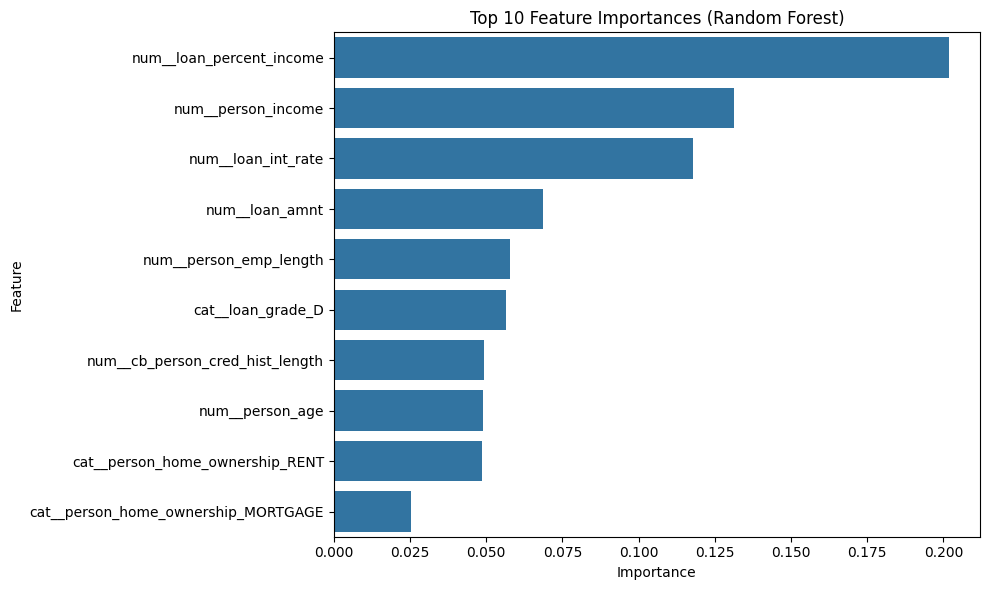


Logistic Regression Coefficients (after L1 Regularization):
                               Feature  Coefficient  Abs_Coefficient
20                   cat__loan_grade_G     3.282380         3.282380
14                   cat__loan_grade_A    -2.004279         2.004279
7       cat__person_home_ownership_OWN    -1.855408         1.855408
15                   cat__loan_grade_B    -1.761334         1.761334
16                   cat__loan_grade_C    -1.516762         1.516762
5             num__loan_percent_income     1.383870         1.383870
19                   cat__loan_grade_F     1.132117         1.132117
18                   cat__loan_grade_E     0.812832         0.812832
11    cat__loan_intent_HOMEIMPROVEMENT     0.749469         0.749469
3                       num__loan_amnt    -0.639034         0.639034
13            cat__loan_intent_VENTURE    -0.634487         0.634487
8      cat__person_home_ownership_RENT     0.600527         0.600527
17                   cat__loan_grade_D    

In [ ]:
print("\n--- 4. Model Comparison and Interpretation ---")

# Compare the performance of different models (including improved ones)
print("\n--- Model Performance Comparison ---")
for name, metrics in evaluation_metrics.items():
    print(f"\n{name}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

print("\n--- Best Random Forest (after tuning) ---")
print(f"Accuracy: {best_rf_accuracy:.4f}, F1-score: {best_rf_f1:.4f}")

print("\n--- Logistic Regression (after feature selection) ---")
print(f"Accuracy: {accuracy_lr_selected:.4f}, F1-score: {f1_lr_selected:.4f}")

# Analyze strengths and weaknesses of each model
print("\n--- Strengths and Weaknesses of Models ---")
print("Logistic Regression: Simple, interpretable, but might not capture complex non-linear relationships.")
print("Decision Tree: Easy to interpret, can capture non-linearities, prone to overfitting.")
print("SVM: Effective in high-dimensional spaces, but can be computationally expensive and harder to interpret.")
print("Naive Bayes: Simple and fast, but assumes feature independence.")
print("Random Forest: Robust, good performance, less prone to overfitting, provides feature importance.")
print("MLP: Can learn complex patterns, but can be a black box and require careful tuning.")

# Interpret the final results (feature importance from tree-based models, coefficients from linear models)
print("\n--- Feature Importance (from Best Random Forest) ---")
importances = best_rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train_resampled_df.columns, 'Importance': importances}) # Use the correct DataFrame
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)
#creates and shows graph
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title('Top 10 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()

if 'lr_selected' in locals():
    coefficients = lr_selected.coef_[0]
    feature_coefficients = pd.DataFrame({'Feature': X_train_selected.columns, 'Coefficient': coefficients})
    # Create a new column for the absolute values
    feature_coefficients['Abs_Coefficient'] = feature_coefficients['Coefficient'].abs()
    # Sort by the *name* of the new column
    feature_coefficients = feature_coefficients.sort_values(by='Abs_Coefficient', ascending=False)
    print("\nLogistic Regression Coefficients (after L1 Regularization):")
    print(feature_coefficients)

print("\n--- End of Project ---")